In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd

from cpsplines.graphics.plot_one_smoothing import plot_curves, plot_surfaces
from cpsplines.fittings.grid_cpsplines import GridCPsplines

The dataset `faithful` contains the waiting time between eruptions and the
duration of the eruption for the Old Faithful geyser in Yellowstone National
Park, Wyoming, USA. Hence, the columns are:
* `eruptions`: Eruption time (in mins)
* `waiting`: Waiting time to next eruption (in mins)

In [3]:
faithful =  pd.read_csv("../data/faithful.csv")

Fit a smooth curve through a series of counts (`waiting` vs `eruptions`) and
plot the results.

In [4]:
example_1 = GridCPsplines(deg=(3,),
                        ord_d=(2,),
                        n_int=(10,),
                        family="poisson")

example_1.fit(x=(faithful["eruptions"].values, ), y=faithful["waiting"].values)

[Solve the problem with smoothing parameters (444.6382517584899,): ] Elapsed time (s): 0.098331


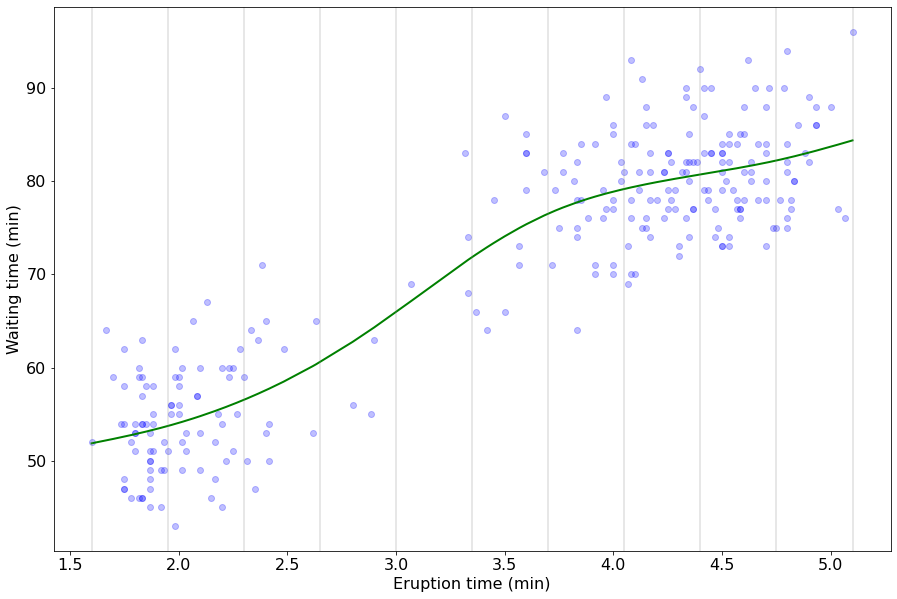

In [5]:
plot1 = plot_curves(
    fittings=(example_1, ),
    col_curve=("g", ),
    knot_positions=True,
    constant_constraints=True,
    x=(faithful["eruptions"].values,), 
    y=(faithful["waiting"].values,),
    col_pt=("b",),
    alpha=0.25
)
_ = plot1[1].set_xlabel("Eruption time (min)", fontsize=16)
_ = plot1[1].set_ylabel("Waiting time (min)", fontsize=16)
_ = plot1[1].tick_params(axis='both', which='major', labelsize=16)

The two-dimensional Poisson P-spline smoother is ideal for histograms, which are
matrices of counts. 

In [6]:
# Generate 100 bins in each direction and the corresponding histogram
xedges = np.linspace(faithful["eruptions"].min(), faithful["eruptions"].max(), 101)
yedges = np.linspace(faithful["waiting"].min(), faithful["waiting"].max(), 101)
y2, xedges, yedges = np.histogram2d(faithful.iloc[:, 0], faithful.iloc[:, 1], (xedges, yedges))
# Compute the mid point of each bins, which will act as covariates
x2_0 = ((xedges[1:] - xedges[:-1]) / 2) + xedges[:100]
x2_1 = ((yedges[1:] - yedges[:-1]) / 2) + yedges[:100]

In [7]:
example_2 = GridCPsplines(deg=(3,3),
                          ord_d=(2,2),
                          n_int=(10,10),
                          sp_method="grid_search",
                          sp_args={"grid": ((0.1,),(0.1,))},
                          family="poisson")
example_2.fit(x=(x2_0, x2_1), y=y2)

[Solve the problem with smoothing parameters (0.1, 0.1): ] Elapsed time (s): 1.843858


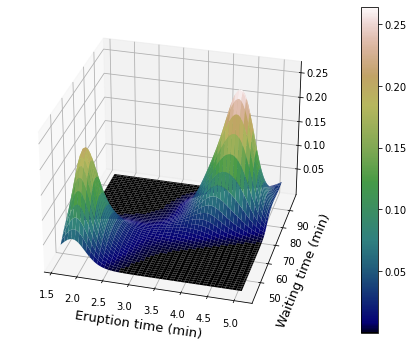

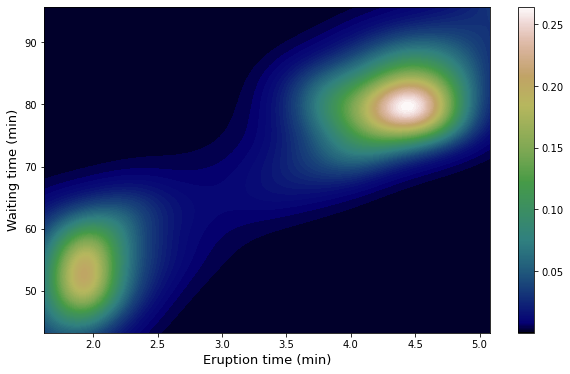

In [8]:
plot2 = plot_surfaces(
    fittings=(example_2,),
    col_surface=("gist_earth",),
    orientation=(30,285),
    figsize=(10, 6))
for plot in plot2:
    _ = plot[1].set_xlabel("Eruption time (min)", fontsize=13)
    _ = plot[1].set_ylabel("Waiting time (min)", fontsize=13)